In [1]:
from minihack import RewardManager
import minihack
from nle import nethack
import random
import numpy as np
import gym
import matplotlib.pyplot as plt

from dqn.agent import DQNAgent
from dqn.replay_buffer import ReplayBuffer
from matplotlib.animation import FuncAnimation, FFMpegWriter
# from dqn.wrappers import WarpFrame,PyTorchFrame,FrameStack,ScaledFloatFrame

In [10]:
# class IdleEvent(minihack.reward_manager.Event):
#     def __init__(self, reward: float, repeatable: bool, terminal_required: bool, terminal_sufficient: bool):
#         super().__init__(reward, repeatable, terminal_required, terminal_sufficient)

#     def check(self, env, previous_observation, action, observation) -> float:
#         # blank spots are 32
#         # agent is 64
#         # agent spawn point is 60
#         # pathways are 35
#         # obs[1] is the char observation 
#         # print("+++++++++++++++++++\nobs = \n++++++++++++++++++++++\n", observation[1])
# #         current = sum(np.count_nonzero(i == 35) for i in observation[0])
# #         current += sum(np.count_nonzero(i == 60) for i in observation[0])
# #         prev = sum(np.count_nonzero(i == 35) for i in previous_observation[0])
# #         prev += sum(np.count_nonzero(i == 60) for i in previous_observation[0])
#         current = observation[0]
#         prev = previous_observation[0]
#         if current > prev:
#             return self.reward
#         else:
#             return 0

hyper_params = {
    "seed": 42,  # which seed to use
    "room-env": "MiniHack-Room-Random-15x15-v0",  # for room task
    "maze-env": "MiniHack-MazeWalk-15x15-v0",  # for maze task
    "lava-env": "MiniHack-LavaCross-Levitate-Potion-Inv-v0",  # for lava crossing task
    "quest-env": "MiniHack-Room-Random-15x15-v0",  # name of the game
    "replay-buffer-size": int(5e3),  # replay buffer size
    "learning-rate": 1e-4,  # learning rate for Adam optimizer
    "discount-factor": 0.99,  # discount factor
    "num-steps": int(1e6),  # total number of steps to run the environment for
    "batch-size": 256,  # number of transitions to optimize at the same time
    "learning-starts": 10000,  # number of steps before learning starts
    "learning-freq": 3,  # number of iterations between every optimization step
    "use-double-dqn": False,  # use double deep Q-learning
    "target-update-freq": 1000,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.5,  # fraction of num-steps
    "print-freq": 10,
}

np.random.seed(hyper_params["seed"])
random.seed(hyper_params["seed"])

ACTIONS = tuple(nethack.CompassDirection)+(
#     nethack.Command.PICKUP,
#     nethack.Command.APPLY,
#     nethack.Command.ZAP,
#     nethack.Command.WEAR,
# #     nethack.Command.PUTON,
    nethack.Command.QUAFF,
    nethack.Command.FIRE)

# reward_manager = RewardManager()
# reward_manager.add_kill_event("minotaur", reward=1, terminal_required=False)
# strings = list()
# strings.append("The door opens.")
# reward_manager.add_message_event(strings, reward=1, terminal_required=True)
# strings = list()
# strings.append("It's solid stone.")
# reward_manager.add_message_event("It's solid stone.", reward=-0.5, terminal_required=False, repeatable=True)

# reward_manager.add_event(ExploreEvent(0.5, True, True, False))
rand_nums = np.random.randint(1000,size=3)
obs_type = 'chars_crop'
env = gym.make(hyper_params['lava-env'],
                observation_keys = [obs_type,'message'],
                obs_crop_w=15,
                penalty_time=-0.01,
#                 penalty_step=-0.1,
                reward_lose=-10,
                reward_win=10,
                seeds = [42],
#                 reward_manager=reward_manager,
                actions = ACTIONS)

replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

agent = DQNAgent(np.prod(env.observation_space[obs_type].shape), env.action_space.n,replay_buffer, hyper_params["use-double-dqn"],hyper_params["learning-rate"],hyper_params["batch-size"],hyper_params["discount-factor"])

cuda


In [ ]:
eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
episode_rewards = [0.0]
losses=[]

state = env.reset()[obs_type]

lava_count = 0
key_count = 0
last_action = None
for t in range(hyper_params["num-steps"]):
    fraction = min(1.0, float(t) / eps_timesteps)
    eps_threshold = hyper_params["eps-start"] + fraction * (
        hyper_params["eps-end"] - hyper_params["eps-start"]
    )
    sample = random.random()
    
    if sample<eps_threshold:
        action = env.action_space.sample()
    else:
        action = agent.act(state)
#     print(action)
    n_state,reward,done,_ = env.step(action)
#     print(n_state['message'])
    n_state = n_state[obs_type]
    
    if action in np.arange(8):
        reward += 0.5
#     if action ==8:
#         key_count += 1
#         if key_count == 1:
#             print('drank potion')
#             reward += 5
    if(last_action ==8 and action == 9):
        lava_count += 1
        if lava_count == 1:
            print('used potion')
            reward = 5

    
    replay_buffer.add(state,action,reward,n_state,float(done))
    state = n_state
    
#     prev_action = last_action
    last_action = action
    

    episode_rewards[-1] += reward
    if done:
        state = env.reset()[obs_type]
        key_count =0
        lava_count=0
        last_action =None
        episode_rewards.append(0.0)

    if (
        t > hyper_params["learning-starts"]
        and t % hyper_params["learning-freq"] == 0
    ):
        losses.append(agent.optimise_td_loss())

#     if (
#         t > hyper_params["learning-starts"]
#         and t % hyper_params["target-update-freq"] == 0
#     ):
#         agent.update_target_network()

    num_episodes = len(episode_rewards)

    if (
        done
        and hyper_params["print-freq"] is not None
        and len(episode_rewards) % hyper_params["print-freq"] == 0
    ):
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        print("********************************************************")
        print("steps: {}".format(t))
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("% time spent exploring: {}".format(int(100 * eps_threshold)))
        print("********************************************************")

used potion
used potion
used potion
used potion
********************************************************
steps: 1600
episodes: 10
mean 100 episode reward: 57.7
% time spent exploring: 99
********************************************************
used potion
used potion
used potion
used potion
used potion
used potion
used potion
********************************************************
steps: 3611
episodes: 20
mean 100 episode reward: 63.2
% time spent exploring: 99
********************************************************
used potion
used potion
used potion
used potion
used potion
used potion
used potion
********************************************************
steps: 5735
episodes: 30
mean 100 episode reward: 67.5
% time spent exploring: 98
********************************************************
used potion
used potion
used potion
used potion
used potion
********************************************************
steps: 7318
episodes: 40
mean 100 episode reward: 63.1
% time spent exploring: 

used potion
used potion
********************************************************
steps: 51208
episodes: 330
mean 100 episode reward: 45.4
% time spent exploring: 89
********************************************************
used potion
used potion
used potion
used potion
used potion
used potion
********************************************************
steps: 53297
episodes: 340
mean 100 episode reward: 49.4
% time spent exploring: 89
********************************************************
used potion
used potion
used potion
used potion
used potion
used potion
used potion
used potion
********************************************************
steps: 55326
episodes: 350
mean 100 episode reward: 52.7
% time spent exploring: 89
********************************************************
used potion
used potion
used potion
used potion
********************************************************
steps: 56479
episodes: 360
mean 100 episode reward: 53.3
% time spent exploring: 88
*************************

used potion
used potion
used potion
********************************************************
steps: 88999
episodes: 660
mean 100 episode reward: 46.2
% time spent exploring: 82
********************************************************
used potion
used potion
used potion
********************************************************
steps: 89444
episodes: 670
mean 100 episode reward: 44.8
% time spent exploring: 82
********************************************************
used potion
used potion
used potion
used potion
********************************************************
steps: 90268
episodes: 680
mean 100 episode reward: 42.8
% time spent exploring: 82
********************************************************
used potion
used potion
used potion
********************************************************
steps: 90925
episodes: 690
mean 100 episode reward: 38.4
% time spent exploring: 81
********************************************************
used potion
****************************************

used potion
********************************************************
steps: 104882
episodes: 1030
mean 100 episode reward: 17.8
% time spent exploring: 79
********************************************************
used potion
used potion
used potion
used potion
********************************************************
steps: 105438
episodes: 1040
mean 100 episode reward: 18.1
% time spent exploring: 79
********************************************************
used potion
used potion
********************************************************
steps: 106085
episodes: 1050
mean 100 episode reward: 18.7
% time spent exploring: 78
********************************************************
********************************************************
steps: 106338
episodes: 1060
mean 100 episode reward: 17.0
% time spent exploring: 78
********************************************************
used potion
used potion
********************************************************
steps: 106664
episodes: 1070
mean 1

used potion
********************************************************
steps: 119827
episodes: 1410
mean 100 episode reward: 8.7
% time spent exploring: 76
********************************************************
********************************************************
steps: 120036
episodes: 1420
mean 100 episode reward: 7.7
% time spent exploring: 76
********************************************************
used potion
********************************************************
steps: 120213
episodes: 1430
mean 100 episode reward: 7.4
% time spent exploring: 76
********************************************************
used potion
********************************************************
steps: 120596
episodes: 1440
mean 100 episode reward: 8.1
% time spent exploring: 76
********************************************************
used potion
********************************************************
steps: 120976
episodes: 1450
mean 100 episode reward: 9.0
% time spent exploring: 76
**************

********************************************************
steps: 129226
episodes: 1800
mean 100 episode reward: 7.0
% time spent exploring: 74
********************************************************
********************************************************
steps: 129542
episodes: 1810
mean 100 episode reward: 7.4
% time spent exploring: 74
********************************************************
used potion
********************************************************
steps: 129746
episodes: 1820
mean 100 episode reward: 7.3
% time spent exploring: 74
********************************************************
used potion
used potion
********************************************************
steps: 129985
episodes: 1830
mean 100 episode reward: 7.9
% time spent exploring: 74
********************************************************
used potion
used potion
********************************************************
steps: 130284
episodes: 1840
mean 100 episode reward: 8.5
% time spent exploring: 74
**

used potion
********************************************************
steps: 138753
episodes: 2190
mean 100 episode reward: 5.2
% time spent exploring: 72
********************************************************
********************************************************
steps: 138870
episodes: 2200
mean 100 episode reward: 4.6
% time spent exploring: 72
********************************************************
used potion
used potion
********************************************************
steps: 139107
episodes: 2210
mean 100 episode reward: 4.3
% time spent exploring: 72
********************************************************
used potion
********************************************************
steps: 139366
episodes: 2220
mean 100 episode reward: 4.8
% time spent exploring: 72
********************************************************
used potion
used potion
********************************************************
steps: 139593
episodes: 2230
mean 100 episode reward: 5.3
% time spent expl

used potion
********************************************************
steps: 147119
episodes: 2580
mean 100 episode reward: 3.9
% time spent exploring: 70
********************************************************
used potion
********************************************************
steps: 147316
episodes: 2590
mean 100 episode reward: 4.7
% time spent exploring: 70
********************************************************
********************************************************
steps: 147508
episodes: 2600
mean 100 episode reward: 4.9
% time spent exploring: 70
********************************************************
used potion
********************************************************
steps: 147713
episodes: 2610
mean 100 episode reward: 4.9
% time spent exploring: 70
********************************************************
********************************************************
steps: 147913
episodes: 2620
mean 100 episode reward: 5.2
% time spent exploring: 70
**************************

********************************************************
steps: 155406
episodes: 2970
mean 100 episode reward: 6.1
% time spent exploring: 69
********************************************************
used potion
used potion
used potion
********************************************************
steps: 155711
episodes: 2980
mean 100 episode reward: 6.9
% time spent exploring: 69
********************************************************
used potion
used potion
********************************************************
steps: 155856
episodes: 2990
mean 100 episode reward: 7.3
% time spent exploring: 69
********************************************************
********************************************************
steps: 156089
episodes: 3000
mean 100 episode reward: 7.3
% time spent exploring: 69
********************************************************
used potion
used potion
used potion
********************************************************
steps: 156275
episodes: 3010
mean 100 episode rewar

used potion
********************************************************
steps: 164144
episodes: 3360
mean 100 episode reward: 11.8
% time spent exploring: 67
********************************************************
********************************************************
steps: 164354
episodes: 3370
mean 100 episode reward: 11.0
% time spent exploring: 67
********************************************************
********************************************************
steps: 164729
episodes: 3380
mean 100 episode reward: 11.1
% time spent exploring: 67
********************************************************
used potion
used potion
********************************************************
steps: 165305
episodes: 3390
mean 100 episode reward: 12.8
% time spent exploring: 67
********************************************************
********************************************************
steps: 165592
episodes: 3400
mean 100 episode reward: 12.3
% time spent exploring: 67
*********************

********************************************************
steps: 174057
episodes: 3750
mean 100 episode reward: 4.1
% time spent exploring: 65
********************************************************
********************************************************
steps: 174278
episodes: 3760
mean 100 episode reward: 4.4
% time spent exploring: 65
********************************************************
********************************************************
steps: 174476
episodes: 3770
mean 100 episode reward: 5.1
% time spent exploring: 65
********************************************************
********************************************************
steps: 174661
episodes: 3780
mean 100 episode reward: 4.5
% time spent exploring: 65
********************************************************
********************************************************
steps: 174895
episodes: 3790
mean 100 episode reward: 4.5
% time spent exploring: 65
********************************************************
used 

used potion
********************************************************
steps: 181490
episodes: 4150
mean 100 episode reward: 3.1
% time spent exploring: 64
********************************************************
********************************************************
steps: 181693
episodes: 4160
mean 100 episode reward: 3.5
% time spent exploring: 64
********************************************************
********************************************************
steps: 181851
episodes: 4170
mean 100 episode reward: 3.3
% time spent exploring: 63
********************************************************
********************************************************
steps: 182036
episodes: 4180
mean 100 episode reward: 3.1
% time spent exploring: 63
********************************************************
********************************************************
steps: 182157
episodes: 4190
mean 100 episode reward: 3.0
% time spent exploring: 63
**************************************************

used potion
********************************************************
steps: 188322
episodes: 4550
mean 100 episode reward: 4.5
% time spent exploring: 62
********************************************************
used potion
********************************************************
steps: 188516
episodes: 4560
mean 100 episode reward: 4.6
% time spent exploring: 62
********************************************************
used potion
********************************************************
steps: 188680
episodes: 4570
mean 100 episode reward: 5.1
% time spent exploring: 62
********************************************************
used potion
used potion
********************************************************
steps: 188919
episodes: 4580
mean 100 episode reward: 5.7
% time spent exploring: 62
********************************************************
********************************************************
steps: 189048
episodes: 4590
mean 100 episode reward: 4.6
% time spent exploring: 62
**

used potion
********************************************************
steps: 195783
episodes: 4950
mean 100 episode reward: 7.0
% time spent exploring: 61
********************************************************
used potion
used potion
********************************************************
steps: 196659
episodes: 4960
mean 100 episode reward: 10.1
% time spent exploring: 61
********************************************************
used potion
********************************************************
steps: 197118
episodes: 4970
mean 100 episode reward: 11.6
% time spent exploring: 60
********************************************************
used potion
used potion
********************************************************
steps: 197628
episodes: 4980
mean 100 episode reward: 13.0
% time spent exploring: 60
********************************************************
used potion
********************************************************
steps: 198092
episodes: 4990
mean 100 episode reward: 14.1
%

********************************************************
steps: 208895
episodes: 5340
mean 100 episode reward: 8.6
% time spent exploring: 58
********************************************************
********************************************************
steps: 209091
episodes: 5350
mean 100 episode reward: 8.6
% time spent exploring: 58
********************************************************
********************************************************
steps: 209263
episodes: 5360
mean 100 episode reward: 8.0
% time spent exploring: 58
********************************************************
********************************************************
steps: 209576
episodes: 5370
mean 100 episode reward: 7.6
% time spent exploring: 58
********************************************************
used potion
********************************************************
steps: 209823
episodes: 5380
mean 100 episode reward: 7.4
% time spent exploring: 58
**************************************************

used potion
********************************************************
steps: 220573
episodes: 5730
mean 100 episode reward: 10.4
% time spent exploring: 56
********************************************************
used potion
********************************************************
steps: 220835
episodes: 5740
mean 100 episode reward: 10.1
% time spent exploring: 56
********************************************************
********************************************************
steps: 221025
episodes: 5750
mean 100 episode reward: 9.2
% time spent exploring: 56
********************************************************
used potion
********************************************************
steps: 221420
episodes: 5760
mean 100 episode reward: 9.7
% time spent exploring: 56
********************************************************
********************************************************
steps: 221725
episodes: 5770
mean 100 episode reward: 10.0
% time spent exploring: 56
***********************

used potion
********************************************************
steps: 232707
episodes: 6120
mean 100 episode reward: 6.9
% time spent exploring: 53
********************************************************
used potion
used potion
********************************************************
steps: 233215
episodes: 6130
mean 100 episode reward: 8.7
% time spent exploring: 53
********************************************************
********************************************************
steps: 233445
episodes: 6140
mean 100 episode reward: 8.7
% time spent exploring: 53
********************************************************
********************************************************
steps: 233656
episodes: 6150
mean 100 episode reward: 8.0
% time spent exploring: 53
********************************************************
********************************************************
steps: 233802
episodes: 6160
mean 100 episode reward: 7.3
% time spent exploring: 53
**************************

********************************************************
steps: 245179
episodes: 6520
mean 100 episode reward: 12.9
% time spent exploring: 51
********************************************************
used potion
********************************************************
steps: 245552
episodes: 6530
mean 100 episode reward: 12.5
% time spent exploring: 51
********************************************************
used potion
********************************************************
steps: 245910
episodes: 6540
mean 100 episode reward: 12.9
% time spent exploring: 51
********************************************************
********************************************************
steps: 246341
episodes: 6550
mean 100 episode reward: 13.4
% time spent exploring: 51
********************************************************
********************************************************
steps: 246641
episodes: 6560
mean 100 episode reward: 12.7
% time spent exploring: 51
*********************************

used potion
********************************************************
steps: 258155
episodes: 6920
mean 100 episode reward: 11.0
% time spent exploring: 48
********************************************************
used potion
********************************************************
steps: 258418
episodes: 6930
mean 100 episode reward: 10.6
% time spent exploring: 48
********************************************************
used potion
********************************************************
steps: 258706
episodes: 6940
mean 100 episode reward: 9.1
% time spent exploring: 48
********************************************************
used potion
used potion
used potion
used potion
********************************************************
steps: 259164
episodes: 6950
mean 100 episode reward: 10.0
% time spent exploring: 48
********************************************************
********************************************************
steps: 259428
episodes: 6960
mean 100 episode reward: 9.2
% 

used potion
********************************************************
steps: 266706
episodes: 7320
mean 100 episode reward: 4.1
% time spent exploring: 47
********************************************************
********************************************************
steps: 266910
episodes: 7330
mean 100 episode reward: 4.4
% time spent exploring: 47
********************************************************
used potion
********************************************************
steps: 267145
episodes: 7340
mean 100 episode reward: 5.2
% time spent exploring: 47
********************************************************
********************************************************
steps: 267458
episodes: 7350
mean 100 episode reward: 6.4
% time spent exploring: 47
********************************************************
********************************************************
steps: 267708
episodes: 7360
mean 100 episode reward: 7.3
% time spent exploring: 46
**************************************

********************************************************
steps: 273344
episodes: 7730
mean 100 episode reward: 1.3
% time spent exploring: 45
********************************************************
********************************************************
steps: 273490
episodes: 7740
mean 100 episode reward: 1.2
% time spent exploring: 45
********************************************************
********************************************************
steps: 273668
episodes: 7750
mean 100 episode reward: 0.8
% time spent exploring: 45
********************************************************
used potion
********************************************************
steps: 273808
episodes: 7760
mean 100 episode reward: 1.2
% time spent exploring: 45
********************************************************
used potion
********************************************************
steps: 273892
episodes: 7770
mean 100 episode reward: 0.8
% time spent exploring: 45
**************************************

********************************************************
steps: 278543
episodes: 8140
mean 100 episode reward: -1.5
% time spent exploring: 44
********************************************************
********************************************************
steps: 278662
episodes: 8150
mean 100 episode reward: -1.8
% time spent exploring: 44
********************************************************
********************************************************
steps: 278732
episodes: 8160
mean 100 episode reward: -2.5
% time spent exploring: 44
********************************************************
used potion
********************************************************
steps: 278877
episodes: 8170
mean 100 episode reward: -1.9
% time spent exploring: 44
********************************************************
********************************************************
steps: 278956
episodes: 8180
mean 100 episode reward: -2.4
% time spent exploring: 44
*********************************************

used potion
********************************************************
steps: 284714
episodes: 8550
mean 100 episode reward: 0.7
% time spent exploring: 43
********************************************************
used potion
********************************************************
steps: 284898
episodes: 8560
mean 100 episode reward: 1.1
% time spent exploring: 43
********************************************************
used potion
********************************************************
steps: 285089
episodes: 8570
mean 100 episode reward: 1.8
% time spent exploring: 43
********************************************************
used potion
********************************************************
steps: 285217
episodes: 8580
mean 100 episode reward: 2.1
% time spent exploring: 43
********************************************************
********************************************************
steps: 285345
episodes: 8590
mean 100 episode reward: 1.2
% time spent exploring: 43
**************

********************************************************
steps: 290477
episodes: 8960
mean 100 episode reward: -1.8
% time spent exploring: 42
********************************************************
********************************************************
steps: 290597
episodes: 8970
mean 100 episode reward: -1.4
% time spent exploring: 42
********************************************************
********************************************************
steps: 290712
episodes: 8980
mean 100 episode reward: -1.7
% time spent exploring: 42
********************************************************
********************************************************
steps: 290829
episodes: 8990
mean 100 episode reward: -1.9
% time spent exploring: 42
********************************************************
********************************************************
steps: 290910
episodes: 9000
mean 100 episode reward: -2.0
% time spent exploring: 42
********************************************************


********************************************************
steps: 295552
episodes: 9380
mean 100 episode reward: -3.9
% time spent exploring: 41
********************************************************
used potion
********************************************************
steps: 295673
episodes: 9390
mean 100 episode reward: -3.5
% time spent exploring: 41
********************************************************
********************************************************
steps: 295755
episodes: 9400
mean 100 episode reward: -3.5
% time spent exploring: 41
********************************************************
********************************************************
steps: 295903
episodes: 9410
mean 100 episode reward: -2.9
% time spent exploring: 41
********************************************************
********************************************************
steps: 296055
episodes: 9420
mean 100 episode reward: -2.2
% time spent exploring: 41
*********************************************

********************************************************
steps: 304462
episodes: 9790
mean 100 episode reward: 15.3
% time spent exploring: 39
********************************************************
********************************************************
steps: 304683
episodes: 9800
mean 100 episode reward: 15.1
% time spent exploring: 39
********************************************************
********************************************************
steps: 304848
episodes: 9810
mean 100 episode reward: 14.1
% time spent exploring: 39
********************************************************
********************************************************
steps: 305046
episodes: 9820
mean 100 episode reward: 13.2
% time spent exploring: 39
********************************************************
used potion
********************************************************
steps: 305332
episodes: 9830
mean 100 episode reward: 13.6
% time spent exploring: 39
*********************************************

********************************************************
steps: 316665
episodes: 10190
mean 100 episode reward: 7.0
% time spent exploring: 37
********************************************************
used potion
********************************************************
steps: 317101
episodes: 10200
mean 100 episode reward: 7.9
% time spent exploring: 37
********************************************************
********************************************************
steps: 317412
episodes: 10210
mean 100 episode reward: 8.3
% time spent exploring: 37
********************************************************
used potion
********************************************************
steps: 317657
episodes: 10220
mean 100 episode reward: 9.0
% time spent exploring: 37
********************************************************
********************************************************
steps: 318139
episodes: 10230
mean 100 episode reward: 10.0
% time spent exploring: 37
********************************

********************************************************
steps: 330438
episodes: 10590
mean 100 episode reward: 11.2
% time spent exploring: 34
********************************************************
used potion
********************************************************
steps: 330703
episodes: 10600
mean 100 episode reward: 9.9
% time spent exploring: 34
********************************************************
********************************************************
steps: 330882
episodes: 10610
mean 100 episode reward: 8.9
% time spent exploring: 34
********************************************************
used potion
********************************************************
steps: 331166
episodes: 10620
mean 100 episode reward: 8.3
% time spent exploring: 34
********************************************************
********************************************************
steps: 331714
episodes: 10630
mean 100 episode reward: 9.6
% time spent exploring: 34
********************************

********************************************************
steps: 361918
episodes: 10990
mean 100 episode reward: 38.2
% time spent exploring: 28
********************************************************
********************************************************
steps: 363231
episodes: 11000
mean 100 episode reward: 38.8
% time spent exploring: 28
********************************************************
********************************************************
steps: 364488
episodes: 11010
mean 100 episode reward: 41.8
% time spent exploring: 27
********************************************************
********************************************************
steps: 365300
episodes: 11020
mean 100 episode reward: 39.5
% time spent exploring: 27
********************************************************
********************************************************
steps: 365970
episodes: 11030
mean 100 episode reward: 37.6
% time spent exploring: 27
****************************************************

********************************************************
steps: 406281
episodes: 11390
mean 100 episode reward: 39.9
% time spent exploring: 19
********************************************************
********************************************************
steps: 407483
episodes: 11400
mean 100 episode reward: 39.5
% time spent exploring: 19
********************************************************
********************************************************
steps: 408480
episodes: 11410
mean 100 episode reward: 38.5
% time spent exploring: 19
********************************************************
********************************************************
steps: 409378
episodes: 11420
mean 100 episode reward: 38.7
% time spent exploring: 18
********************************************************
********************************************************
steps: 410947
episodes: 11430
mean 100 episode reward: 41.2
% time spent exploring: 18
****************************************************

********************************************************
steps: 453716
episodes: 11800
mean 100 episode reward: 55.5
% time spent exploring: 10
********************************************************
********************************************************
steps: 456320
episodes: 11810
mean 100 episode reward: 59.3
% time spent exploring: 9
********************************************************
********************************************************
steps: 458657
episodes: 11820
mean 100 episode reward: 65.7
% time spent exploring: 9
********************************************************
********************************************************
steps: 460099
episodes: 11830
mean 100 episode reward: 64.4
% time spent exploring: 8
********************************************************
********************************************************
steps: 461885
episodes: 11840
mean 100 episode reward: 67.3
% time spent exploring: 8
********************************************************

In [24]:
agent.save_models('WoD')

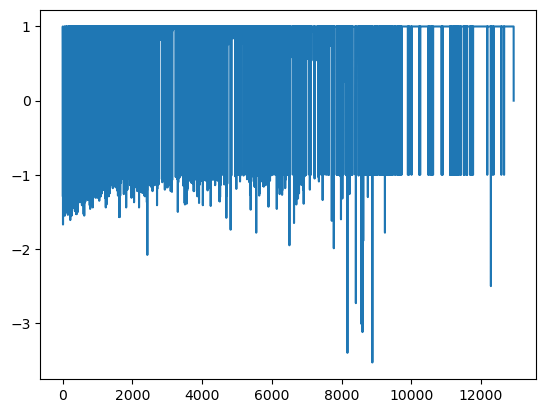

In [13]:
plt.plot(np.array(episode_rewards))

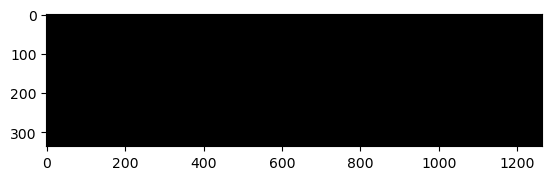

Video saved to path: video.mp4


In [13]:
# test_env = gym.make(ENVIRONMENT_NAME, new_step_api=True, actions=ACTION_KEYS, observation_keys=OBSERVATION_KEYS)
# obs_type = 'chars_crop'

test_env = gym.make(hyper_params['lava-env'],
                observation_keys = [obs_type,'message','pixel'],
                penalty_time=-0.01,
                penalty_step=-0.1,
                obs_crop_w=15,
                reward_lose=-1,
                reward_win=1,
                seeds = [42],
#                 reward_manager=reward_manager,
                actions = ACTIONS)
raw_state = test_env.reset()
state = raw_state[obs_type]

PIXEL_HISTORY = [raw_state["pixel"]]

while True:
    
    action = agent.act(state)
    next_state, _, done, _ = test_env.step(action)

    PIXEL_HISTORY.append(next_state["pixel"])

    if done:
        break

    state = next_state[obs_type]

test_env.close()

fig = plt.figure()
anim = plt.imshow(raw_state["pixel"])
def update_animation_frame(i):
    anim.set_data(PIXEL_HISTORY[i])
    return [anim]
ani = FuncAnimation(fig, update_animation_frame, frames=len(PIXEL_HISTORY), interval=500)
ani.save("video4" + ".mp4", dpi=300, writer=FFMpegWriter(fps=1))
plt.show()

print("Video saved to path: " + "video" + ".mp4")

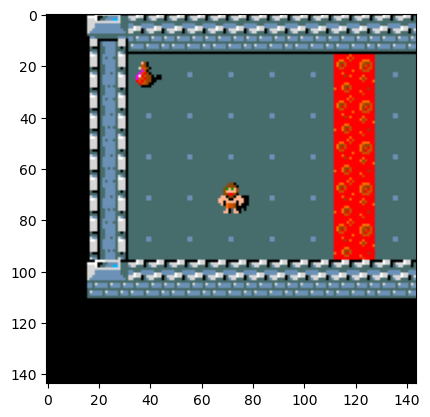

In [70]:
state = env.reset()
plt.imshow(state['pixel_crop'])

In [1]:
import torch
torch.cuda.is_available()

True